In [87]:
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import LineString

import road

In [88]:
bbox =(48.7861400822045,2.197526708826558,48.93467868121917,2.4458831002388592)
bbox = (45.35276166629745, -74.12530920957301, 45.767754586870245, -73.20753918222151)


highway_list = ["motorway", "motorway_link", "trunk", "trunk_link", "primary", "primary_link", 
                "secondary", "secondary_link", "tertiary", "tertiary_link"]
highway_list = ['motorway',
        'motorway_link',
        'trunk',
        'trunk_link',
        'primary',
        'primary_link',
        'secondary',
        'secondary_link',
        'tertiary',
        'tertiary_link',
        'residential',
        'service',
        'unclassified']

In [89]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query ="""
[out:json][timeout:180];
(
"""
overpass_query += ''.join([f'way["highway"="{highway}"]{bbox};\n' for highway in highway_list])
overpass_query +=""" 
);
out body;
>;
out skel qt;
"""

response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [90]:
{'overpass_query': overpass_query,'tags': ['highway', 'maxspeed', 'lanes', 'name', 'oneway', 'surface','direction']}

{'overpass_query': '\n[out:json][timeout:180];\n(\nway["highway"="motorway"](45.35276166629745, -74.125309209573, 45.76775458687025, -73.20753918222151);\nway["highway"="motorway_link"](45.35276166629745, -74.125309209573, 45.76775458687025, -73.20753918222151);\nway["highway"="trunk"](45.35276166629745, -74.125309209573, 45.76775458687025, -73.20753918222151);\nway["highway"="trunk_link"](45.35276166629745, -74.125309209573, 45.76775458687025, -73.20753918222151);\nway["highway"="primary"](45.35276166629745, -74.125309209573, 45.76775458687025, -73.20753918222151);\nway["highway"="primary_link"](45.35276166629745, -74.125309209573, 45.76775458687025, -73.20753918222151);\nway["highway"="secondary"](45.35276166629745, -74.125309209573, 45.76775458687025, -73.20753918222151);\nway["highway"="secondary_link"](45.35276166629745, -74.125309209573, 45.76775458687025, -73.20753918222151);\nway["highway"="tertiary"](45.35276166629745, -74.125309209573, 45.76775458687025, -73.20753918222151);\

In [91]:
"""
[out:json][timeout:180][bbox:{{bbox}}];
(
way["highway"="residential"]; // find all nodes in current bounding box with start_date tag
);
convert way 
    ::id = id(),
	"nodes" = geometry, // Should be implemened in futur version
	"oneway" = t["oneway"];
out body;
>;
out skel qt;
"""

'\n[out:json][timeout:180][bbox:{{bbox}}];\n(\nway["highway"="residential"]; // find all nodes in current bounding box with start_date tag\n);\nconvert way \n    ::id = id(),\n\t"nodes" = geometry, // Should be implemened in futur version\n\t"oneway" = t["oneway"];\nout body;\n>;\nout skel qt;\n'

overpass_url = "http://overpass-api.de/api/interpreter"
data = []
for highway in highway_list:
    overpass_query ="""
    [out:json][timeout:180];
    (
    """
    overpass_query += ''.join(f'way["highway"={highway}]{bbox};\n')
    overpass_query +=""" 
    );
    out body;
    >;
    out skel qt;
    """
    data.append(overpass_query)


import asyncio
import aiohttp
import time

async def get(url, data, session):
    try:
        async with session.get(url=url, data=data) as response:
            resp = await response.json()
            print("Successfully got url {} with resp of length {}.".format(url, len(resp)))
            return await response
    except Exception as e:
        print("Unable to get url {} due to {}.".format(url, e.__class__))


async def main(url, data):
    async with aiohttp.ClientSession() as session:
        ret = await asyncio.gather(*[get(url, d, session) for d in data])
    print("Finalized all. Return is a list of len {} outputs.".format(len(ret)))
    return ret

In [92]:
pd.DataFrame([d for d in data['elements'] if d['type'] == 'way']).set_index('id')

,type,nodes,tags
id,,,
3453107,way,"[35834692, 9775746790]","{'NHS': 'yes', 'highway': 'motorway', 'lanes':..."
4320292,way,"[26232358, 5071727108]","{'bicycle': 'no', 'foot': 'no', 'highway': 'tr..."
4320351,way,"[8997083710, 6188320842, 8996944085, 899694409...","{'bicycle': 'yes', 'cycleway:both': 'no', 'foo..."
4320452,way,"[1454537655, 8997083697, 8997083696, 214840127...","{'cycleway:right': 'no', 'foot': 'use_sidepath..."
4320453,way,"[26233006, 6893619161, 26233012, 9030151348, 9...","{'foot': 'use_sidepath', 'highway': 'residenti..."
...,...,...,...
1168453755,way,"[6432479210, 6432479235, 6432479234, 643247923...","{'highway': 'service', 'oneway': 'yes'}"
1168517344,way,"[10867308578, 10867308579, 10867308580, 108673...","{'highway': 'service', 'image': 'https://web.a..."
1168517345,way,"[10867308577, 10867308587, 10867308578]",{'highway': 'service'}


response = await main(overpass_url, data)

In [93]:
way = pd.DataFrame([d for d in data['elements'] if d['type'] == 'way']).set_index('id')
nodes = pd.DataFrame([d for d in data['elements'] if d['type'] == 'node']).set_index('id')

way_exploded = way.explode('nodes').merge(nodes[['lat','lon']], left_on='nodes', right_index=True, how='left')

geom = way_exploded.groupby('id')[['lon', 'lat']].apply(lambda x: LineString(x.values))
geom.name = 'geometry'
way = gpd.GeoDataFrame(way.join(geom), crs=4326)


/home/boivin/.pyenv/versions/quetzal_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [94]:
tags = pd.DataFrame.from_records(way['tags'].values, index=way['tags'].index)
cols = ['highway', 'maxspeed', 'lanes', 'name', 'oneway', 'surface']

In [95]:
#for col in tags.columns:
#    print(col)

In [96]:
way_tags = way.drop(columns=['nodes', 'tags'], errors='ignore').join(tags[cols])

In [97]:
# OSMNX add edges speed, length and time
# garder les liens fortement connexes
# retirer les noeuds de degree 2

In [98]:
# SOME CLEANING ON THE ONEWAY ... Work In Progress
way_tags['oneway'].fillna('no', inplace=True)
way_tags['oneway'] = way_tags['oneway'].replace('yes', True).replace('no', False).replace('-1', False).replace(-1, False).replace('alternating',False).replace('reversible',False)


In [99]:
way_tags['highway'].unique()

array(['motorway', 'trunk', 'secondary', 'tertiary', 'residential',
       'service', 'trunk_link', 'motorway_link', 'tertiary_link',
       'primary_link', 'primary', 'unclassified', 'secondary_link'],
      dtype=object)

In [118]:
if False
    zones = gpd.read_file('road_links_exemple.geojson')
    from shapely.ops import unary_union
    hull = unary_union(zones['geometry'].buffer(0.002))
    way_tags = way_tags.loc[way_tags['geometry'].apply(lambda g: hull.contains(g))]


In [132]:
way_tags.to_file('way.geojson',driver='GeoJSON')

In [229]:
links, nodes = road.get_links_and_nodes('way.geojson', split_direction=False)
nodes = nodes.set_crs(links.crs)

In [230]:
links = links[links['highway']!='service']

<Axes: >

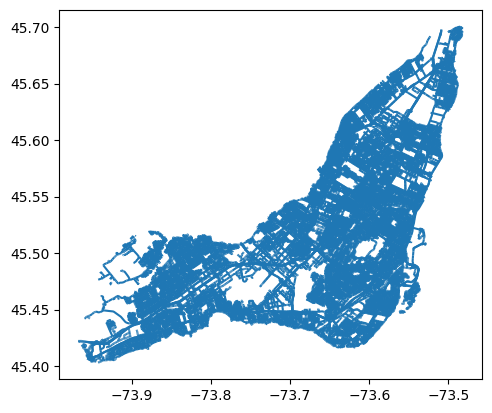

In [231]:
links.plot()

In [232]:

#fig, ax = plt.subplots(figsize=(10,10))
#ax.plot(*hull.exterior.xy,color='red')
#links.plot(ax=ax)



In [233]:
def clean_lanes(links):
    '''
    remove ; in lanes
    '''
    try:
        index = links['lanes'].astype(str).str.lower().str.contains(';')
        links.loc[index,'lanes'] = links.loc[index,'lanes'].str.split(';').apply(lambda x: np.mean([float(xi) for xi in x]))
    except:
        print('fail to convert mph in maxspeed to float ')
    # this remove all strings lefts
    links['maxspeed'] = links['maxspeed'].apply(pd.to_numeric, errors='coerce')
    return links

In [234]:
print(len(way_tags))
print(len(links))

61995
66344


In [235]:
links = road.clean_maxspeed(links)

In [236]:
links = clean_lanes(links)

In [237]:
links = road.rectify_geometry_direction(links,nodes)

0 geometry to inverse


In [238]:
links = road.drop_duplicated_links(links)

344 links dropped


In [239]:
len(links)

66000

In [240]:
links, unmerged = road.simplify(links)
len(links)

23046 deg 2 nodes
find path with large cutoff for 9  origins
find path with large cutoff for 15  origins
find path with large cutoff for 26  origins
find path with large cutoff for 1  origins
find path with large cutoff for 3  origins
find path with large cutoff for 1  origins
find path with large cutoff for 3  origins
find path with large cutoff for 80  origins
find path with large cutoff for 103  origins
find path with large cutoff for 28  origins
find path with large cutoff for 33  origins
0 links were not merge because the oneway field is not the same
0 links were not merge because the highway field is not the same
4099 merged_links unmerged because the geometry became a multilinestring


51445

In [241]:
#links = road.split_oneway(links)
#len(links)

In [214]:
links = road.main_strongly_connected_component(links,None,True)
len(links)

50881

In [242]:
def process_list_in_col(col_values,new_type,function):
    if isinstance(col_values, list):
        return  function([new_type(val) for val in col_values])
    else:
        return new_type(col_values)
    
def remove_list_in_col(col_values,method='first'):
    if isinstance(col_values, list):
        if method == 'first':
            return col_values[0]
        else:
            return col_values[-1]
        
    else:
        return col_values
    
links['maxspeed'] = links['maxspeed'].apply(lambda x: process_list_in_col(x,float,np.nanmean))
links['lanes'] = links['lanes'].apply(lambda x: process_list_in_col(x,float,np.nanmean)).apply(lambda x: np.floor(x))

/tmp/ipykernel_272444/3507984463.py:3: RuntimeWarning: Mean of empty slice
  return  function([new_type(val) for val in col_values])


In [243]:
for col in ['id', 'type', 'highway','name','surface']:
    links[col] = links[col].apply(lambda x: remove_list_in_col(x,'first'))

In [244]:
links['length'] = links.to_crs(32618).length


In [245]:

speed_dict = links.dropna().groupby('highway')['maxspeed'].agg(np.mean).to_dict()
links.loc[~np.isfinite(links['maxspeed']),'maxspeed'] = links.loc[~np.isfinite(links['maxspeed']),'highway'].apply(lambda x: speed_dict.get(x))
links['time'] = links['length']/(links['maxspeed']*1000/3600)

In [246]:
links['maxspeed'].unique()

array([ 40.        ,  30.        , 100.        ,  50.        ,
        70.        ,  32.646492  ,  39.21175749,  43.84189723,
        80.        ,  10.        ,  44.43040086,  97.27272727,
        20.        ,  60.        ,  46.92307692,  47.63333333,
        15.        ,  49.3837535 ,  45.09259259,  46.66666667,
        45.        ,  42.        ,  43.75      ,  36.66666667,
        35.71428571,  44.        ,  45.71428571,  41.66666667,
        34.        ,  38.57142857,  35.        ,  43.33333333,
        36.        ,   5.        ,  33.33333333,  56.66666667,
        53.33333333,  38.        ,  46.        ,  75.        ,
        78.57142857,  87.5       ,  63.33333333,  55.        ,
        83.33333333,  82.        ,  51.11111111,  68.57142857,
        85.        ,  58.57142857,  95.71428571,  90.        ,
        67.5       ,  67.14285714])

In [247]:
links['lanes'] = pd.to_numeric(links['lanes'])
lane_dict = links.groupby('highway')['lanes'].agg(np.nanmean).apply(lambda x: np.floor(x)).to_dict()
links.loc[~np.isfinite(links['lanes']),'lanes'] = links.loc[~np.isfinite(links['lanes']),'highway'].apply(lambda x: lane_dict.get(x))


In [248]:
links = links.drop(columns=['id','type','surface'])
links.geometry = links.simplify(0.00003)

In [249]:
links = links.reset_index(drop=True)
links.index = 'road_link_'+links.index.astype(str)

nodes_set = set(links['a']).union(set(links['b']))

nodes = nodes.loc[nodes_set].sort_index()


/tmp/ipykernel_272444/722026835.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  nodes = nodes.loc[nodes_set].sort_index()


In [250]:
links = road.drop_duplicated_links(links)


27 links dropped


In [251]:
links = links.rename(columns={'maxspeed':'speed'})

In [252]:
colorDict={
'motorway': 'E892A2',
'motorway_link': 'E892A2',
'trunk': 'E892A2',
'trunk_link': 'E892A2',
'primary': 'FCD6A4',
'primary_link': 'FCD6A4',
'secondary': 'F7F9BE',
'secondary_link': 'F7F9BE',
'tertiary': '808080',
'tertiary_link': '808080',
'residential': '808080',
'service': '808080',
'unclassified': '808080',
'cycleway': '1D8621',
}
    
widthDict= {
'motorway': 4,
'motorway_link': 4,
'trunk': 4,
'trunk_link': 4,
'primary': 4,
'primary_link': 4,
'secondary': 3,
'secondary_link': 3,
'tertiary': 2,
'tertiary_link': 2,
'residential': 2,
'service': 2,
'unclassified': 2,
'cycleway': 2,
}
    

In [253]:
links['route_color']=links['highway'].apply(lambda x: colorDict.get(x))
links['route_width']=links['highway'].apply(lambda x: widthDict.get(x))

In [254]:
links.to_file('road_links.geojson')
nodes.to_file('road_nodes.geojson')

In [192]:
df  = gpd.read_file('base/road_links.geojson')



In [193]:
df.set_index('highway')['route_width'].to_dict()

{'motorway': '4',
 'secondary': '3',
 'motorway_link': '4',
 'primary': '4',
 'unclassified': '2',
 'tertiary': '2',
 'secondary_link': '3',
 'primary_link': '4',
 'tertiary_link': '2',
 'trunk_link': '4',
 'trunk': '4'}

In [195]:
links['oneway'].unique()

array([ True, False])

In [163]:
from road import *
links, nodes = road.get_links_and_nodes('way.geojson', split_direction=False)
nodes = nodes.set_crs(links.crs)
len(links)

19868

In [164]:
#remove string in maxspeed
links = clean_maxspeed(links)
len(links)

19868

In [165]:
# make sure the geometry are in the right direction (a->b)
links = rectify_geometry_direction(links,nodes)

0 geometry to inverse


In [166]:
# remove duplicated links (a-b)
print("simplifying links ...")
links = drop_duplicated_links(links)
len(links)

simplifying links ...
1 links dropped


19867

In [169]:
links, nodes = main_strongly_connected_component(links, nodes,split_direction=True)

In [172]:
# simplify. remove deg 2 nodes when possible. group by oneway and highway to merge each links.
links = simplify(links)
len(links)

4174 deg 2 nodes
find path with large cutoff for 50  origins
find path with large cutoff for 41  origins
find path with large cutoff for 23  origins
find path with large cutoff for 1  origins
find path with large cutoff for 11  origins
find path with large cutoff for 13  origins
find path with large cutoff for 4  origins
0 links were not merge because the oneway field is not the same
0 links were not merge because the highway field is not the same
1 merged_links unmerged because the geometry became a multilinestring


7668

In [173]:
links['oneway'].unique()

array(['1', '0', 'reversible'], dtype=object)

In [174]:

# split onwway into 2 links a-b, b-a
links = split_oneway(links)
len(links)

7668

In [177]:
def process_list_in_col(col_values,new_type,function):
        if isinstance(col_values, list):
            return  function([new_type(val) for val in col_values])
        else:
            return new_type(col_values)
        
def remove_list_in_col(col_values,method='first'):
    if isinstance(col_values, list):
        if method == 'first':
            return col_values[0]
        else:
            return col_values[-1]
        
    else:
        return col_values
def get_epsg(lat, lon):
    return int(32700 - round((45 + lat) / 90, 0) * 100 + round((183 + lon) / 6, 0))


print('removing list in columns ...')
links['maxspeed'] = links['maxspeed'].apply(lambda x: process_list_in_col(x,float,np.nanmean))
links['lanes'] = links['lanes'].apply(lambda x: process_list_in_col(x,float,np.nanmean)).apply(lambda x: np.floor(x))
for col in ['id', 'type', 'highway','name','surface']:
    links[col] = links[col].apply(lambda x: remove_list_in_col(x,'first'))

# Add length
print("Write Links and Nodes ...")
epsg = get_epsg(nodes.iloc[0]['geometry'].y, nodes.iloc[0]['geometry'].x)
links['length'] = links.to_crs(epsg).length
len(links)

removing list in columns ...
Write Links and Nodes ...


/tmp/ipykernel_67534/2942894362.py:3: RuntimeWarning: Mean of empty slice
  return  function([new_type(val) for val in col_values])


7668

In [178]:
# Add Speed
try:
    speed_dict = links.dropna().groupby('highway')['maxspeed'].agg(np.mean).to_dict()
    links.loc[~np.isfinite(links['maxspeed']),'maxspeed'] = links.loc[~np.isfinite(links['maxspeed']),'highway'].apply(lambda x: speed_dict.get(x))
except:
    print('fail to convert NaN maxspeed to the average max speed (by highway)')
try:
    links['lanes'] = pd.to_numeric(links['lanes'])
    lane_dict = links.groupby('highway')['lanes'].agg(np.nanmean).apply(lambda x: np.floor(x)).to_dict()
    links.loc[~np.isfinite(links['lanes']),'lanes'] = links.loc[~np.isfinite(links['lanes']),'highway'].apply(lambda x: lane_dict.get(x))
except:
    print('fail to convert NaN Lane to the average lanes (by highway)')
len(links)

7668

In [179]:
links['time'] = links['length']/(links['maxspeed']*1000/3600)
links = links.rename(columns = {'maxspeed' : 'speed'})

# reindex and remove ununsed nodes
links = links.reset_index(drop=True)
links.index = 'road_link_'+links.index.astype(str)
nodes_set = set(links['a']).union(set(links['b']))
nodes = nodes.loc[list(nodes_set)].sort_index()
len(links)

7668

In [ ]:
links.to_file('road_links.geojson')
nodes.to_file('road_nodes.geojson')

In [4]:
from road import *

In [5]:
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

# Extract elements from response
print("Convert to GeoPandas ...")
way = pd.DataFrame([d for d in data['elements'] if d['type'] == 'way']).set_index('id')
nodes = pd.DataFrame([d for d in data['elements'] if d['type'] == 'node']).set_index('id')

# Convert elements to GeoPandas 
way_exploded = way.explode('nodes').merge(nodes[['lat','lon']], left_on='nodes', right_index=True, how='left')
geom = way_exploded.groupby('id')[['lon', 'lat']].apply(lambda x: LineString(x.values))
geom.name = 'geometry'
way = gpd.GeoDataFrame(way.join(geom))

# Filter tags and write networks
print("Write (way.geojson) ...")
tags = pd.DataFrame.from_records(way['tags'].values, index=way['tags'].index)
cols = ['highway', 'maxspeed', 'lanes', 'name', 'oneway', 'surface']
way_tags = way.drop(columns=['nodes', 'tags'], errors='ignore').join(tags[cols])

# SOME CLEANING ON THE ONEWAY ... Work In Progress
way_tags['oneway'].fillna('no', inplace=True)
way_tags['oneway'] = way_tags['oneway'].replace('yes', True).replace('no', False).replace('-1', False).replace(-1, False).replace('alternating',False).replace('reversible',False)
way_tags.to_file('way.geojson')

NameError: name 'overpass_url' is not defined

In [3]:
from road import *
print("Convert ways to links and node ...")
links, nodes = road.get_links_and_nodes('way.geojson', split_direction=False)
nodes = nodes.set_crs(links.crs)

#remove string in maxspeed
links = clean_maxspeed(links)

# make sure the geometry are in the right direction (a->b)
links = rectify_geometry_direction(links,nodes)

# remove duplicated links (a-b)
print("simplifying links ...")
links = drop_duplicated_links(links)

# Clean Cul de Sac
print("Remove Cul de Sac ...")
links, nodes = main_strongly_connected_component(links, nodes, split_direction=True)

Convert ways to links and node ...
0 geometry to inverse
simplifying links ...
1 links dropped
Remove Cul de Sac ...


In [4]:
links=rectify_geometry_direction(links,nodes)

0 geometry to inverse


(45.53, 45.55)

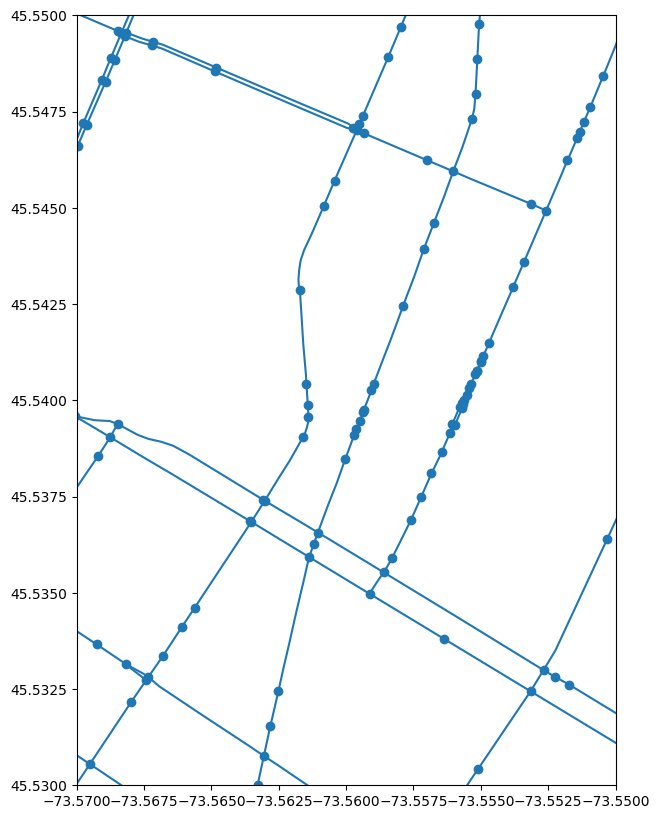

In [5]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
links.plot(ax=ax)
nodes.plot(ax=ax)
plt.xlim([-73.57,-73.55])
plt.ylim([45.53,45.55])

In [6]:
# simplify. remove deg 2 nodes when possible. group by oneway and highway to merge each links.
links,unmerged = simplify(links,cutoff=10)

4447 deg 2 nodes
find path with large cutoff for 48  origins
find path with large cutoff for 38  origins
find path with large cutoff for 23  origins
find path with large cutoff for 1  origins
find path with large cutoff for 26  origins
find path with large cutoff for 31  origins
find path with large cutoff for 10  origins
0 links were not merge because the oneway field is not the same
0 links were not merge because the highway field is not the same
660 merged_links unmerged because the geometry became a multilinestring


In [7]:
nodes_set = set(links['a']).union(set(links['b']))
nodes_test = nodes.loc[list(nodes_set)].sort_index()

(45.53, 45.55)

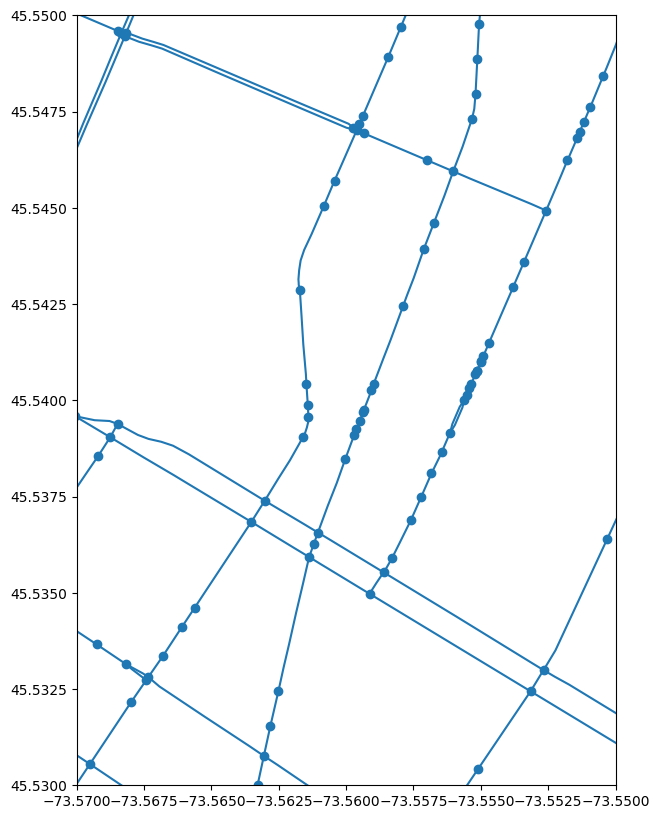

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
links.plot(ax=ax)
nodes_test.plot(ax=ax)
#nodes_test.loc[sources].plot(ax=ax,color='red')
plt.xlim([-73.57,-73.55])
plt.ylim([45.53,45.55])

In [10]:
def process_list_in_col(col_values,new_type,function):
        if isinstance(col_values, list):
            return  function([new_type(val) for val in col_values])
        else:
            return new_type(col_values)
        
def remove_list_in_col(col_values,method='first'):
    if isinstance(col_values, list):
        if method == 'first':
            return col_values[0]
        else:
            return col_values[-1]
        
    else:
        return col_values

def get_epsg(lat, lon):
    return int(32700 - round((45 + lat) / 90, 0) * 100 + round((183 + lon) / 6, 0))


print('removing list in columns ...')
links['maxspeed'] = links['maxspeed'].apply(lambda x: process_list_in_col(x,float,np.nanmean))
links['lanes'] = links['lanes'].apply(lambda x: process_list_in_col(x,float,np.nanmean)).apply(lambda x: np.floor(x))
for col in ['id', 'type', 'highway','name','surface']:
    links[col] = links[col].apply(lambda x: remove_list_in_col(x,'first'))

# Add length
print("Write Links and Nodes ...")
epsg = get_epsg(nodes.iloc[0]['geometry'].y, nodes.iloc[0]['geometry'].x)
links['length'] = links.to_crs(epsg).length

# Add Speed
try:
    speed_dict = links.dropna().groupby('highway')['maxspeed'].agg(np.mean).to_dict()
    links.loc[~np.isfinite(links['maxspeed']),'maxspeed'] = links.loc[~np.isfinite(links['maxspeed']),'highway'].apply(lambda x: speed_dict.get(x))
except:
    print('fail to convert NaN maxspeed to the average max speed (by highway)')
try:
    links['lanes'] = pd.to_numeric(links['lanes'])
    lane_dict = links.groupby('highway')['lanes'].agg(np.nanmean).apply(lambda x: np.floor(x)).to_dict()
    links.loc[~np.isfinite(links['lanes']),'lanes'] = links.loc[~np.isfinite(links['lanes']),'highway'].apply(lambda x: lane_dict.get(x))
except:
    print('fail to convert NaN Lane to the average lanes (by highway)')
# Add Time
links['time'] = links['length']/(links['maxspeed']*1000/3600)
links = links.rename(columns = {'maxspeed' : 'speed'})

# reindex and remove ununsed nodes
links = links.reset_index(drop=True)
links.index = 'road_link_'+links.index.astype(str)
nodes_set = set(links['a']).union(set(links['b']))
nodes = nodes.loc[list(nodes_set)].sort_index()

removing list in columns ...
Write Links and Nodes ...


/tmp/ipykernel_81147/772384264.py:3: RuntimeWarning: Mean of empty slice
  return  function([new_type(val) for val in col_values])


In [9]:
unmerged

,id,type,highway,maxspeed,lanes,name,oneway,surface,a,b,geometry,weight,group
,,,,,,,,,,,,,
road_link_713,"[499309062, 1017867981, 1017867981, 499309062]",way,tertiary,50.0,NaN,Chemin du Coteau-Rouge,False,NaN,road_node_1342,road_node_10438,"MULTILINESTRING ((-73.49875 45.51527, -73.4983...",1,2714
road_link_11442,"[921103182, 636899611, 4886357, 697467547, 606...",way,tertiary,"[50.0, 50.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40....",2,"[Chemin Remembrance, Chemin Remembrance, Voie ...",False,asphalt,road_node_2428,road_node_11848,"MULTILINESTRING ((-73.60164 45.49849, -73.6012...",1,2733
road_link_10181,"[600826245, 182756781, 609573123, 609573123, 1...",way,tertiary,40.0,2,Voie Camillien-Houde,False,asphalt,road_node_6240,road_node_12693,"MULTILINESTRING ((-73.59263 45.51346, -73.5929...",1,2744
road_link_14690,"[1044092600, 427701163, 427701163, 1044092600]",way,tertiary,40.0,2,Rue de Cadillac,False,asphalt,road_node_9101,road_node_14639,"MULTILINESTRING ((-73.54982 45.57791, -73.5518...",1,2746
road_link_103,"[24545583, 25939197, 25939197, 24545583]",way,tertiary,"[nan, nan, nan, nan]","[nan, 2, 2, nan]",Avenue Bienville,False,"[nan, asphalt, asphalt, nan]",road_node_9319,road_node_13046,"MULTILINESTRING ((-73.45332 45.46973, -73.4535...",1,2755
...,...,...,...,...,...,...,...,...,...,...,...,...,...
road_link_5201,"[395307468, 329066841, 329066846, 1025971047, ...",way,primary,50.0,"[6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",Rue Sherbrooke Est,False,asphalt,road_node_9028,road_node_6167,"MULTILINESTRING ((-73.56003 45.53848, -73.5597...",1,4022
road_link_6784,"[453725261, 1161109088, 1161109087, 1161109086...",way,primary,40.0,"[5, 5, 4, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",Rue Sherbrooke Ouest,False,asphalt,road_node_7383,road_node_13185,"MULTILINESTRING ((-73.60344 45.47898, -73.6033...",1,4023
road_link_3945,"[147994583, 147994580, 1133488647, 430273942, ...",way,secondary_link,50.0,2,Boulevard Saint-Martin Ouest,False,asphalt,road_node_2465,road_node_8071,"MULTILINESTRING ((-73.71676 45.57348, -73.7167...",1,4027


In [29]:
print("Convert ways to links and node ...")
links, nodes = road.get_links_and_nodes('way.geojson', split_direction=False)
nodes = nodes.set_crs(links.crs)

#remove string in maxspeed
links = clean_maxspeed(links)

# make sure the geometry are in the right direction (a->b)
links = rectify_geometry_direction(links,nodes)

# remove duplicated links (a-b)
print("simplifying links ...")
links = drop_duplicated_links(links)


# simplify. remove deg 2 nodes when possible. group by oneway and highway to merge each links.
links = simplify(links)

# split onwway into 2 links a-b, b-a
links = split_oneway(links)

# Clean Cul de Sac
print("Remove Cul de Sac ...")
links, nodes = main_strongly_connected_component(links, nodes, split_direction=False)

print('removing list in columns ...')
links['maxspeed'] = links['maxspeed'].apply(lambda x: process_list_in_col(x,float,np.nanmean))
links['lanes'] = links['lanes'].apply(lambda x: process_list_in_col(x,float,np.nanmean)).apply(lambda x: np.floor(x))
for col in ['id', 'type', 'highway','name','surface']:
    links[col] = links[col].apply(lambda x: remove_list_in_col(x,'first'))

# Add length
print("Write Links and Nodes ...")
epsg = get_epsg(nodes.iloc[0]['geometry'].y, nodes.iloc[0]['geometry'].x)
links['length'] = links.to_crs(epsg).length

# Add Speed
try:
    speed_dict = links.dropna().groupby('highway')['maxspeed'].agg(np.mean).to_dict()
    links.loc[~np.isfinite(links['maxspeed']),'maxspeed'] = links.loc[~np.isfinite(links['maxspeed']),'highway'].apply(lambda x: speed_dict.get(x))
except:
    print('fail to convert NaN maxspeed to the average max speed (by highway)')
try:
    links['lanes'] = pd.to_numeric(links['lanes'])
    lane_dict = links.groupby('highway')['lanes'].agg(np.nanmean).apply(lambda x: np.floor(x)).to_dict()
    links.loc[~np.isfinite(links['lanes']),'lanes'] = links.loc[~np.isfinite(links['lanes']),'highway'].apply(lambda x: lane_dict.get(x))
except:
    print('fail to convert NaN Lane to the average lanes (by highway)')
# Add Time
links['time'] = links['length']/(links['maxspeed']*1000/3600)
links = links.rename(columns = {'maxspeed' : 'speed'})

# reindex and remove ununsed nodes
links = links.reset_index(drop=True)
links.index = 'road_link_'+links.index.astype(str)
nodes_set = set(links['a']).union(set(links['b']))
nodes = nodes.loc[list(nodes_set)].sort_index()

Convert ways to links and node ...
0 geometry to inverse
simplifying links ...
1 links dropped
4731 deg 2 nodes
find path with large cutoff for 49  origins
find path with large cutoff for 41  origins
find path with large cutoff for 23  origins
find path with large cutoff for 3  origins
find path with large cutoff for 26  origins
find path with large cutoff for 31  origins
find path with large cutoff for 10  origins
0 links were not merge because the oneway field is not the same
0 links were not merge because the highway field is not the same
668 merged_links unmerged because the geometry became a multilinestring


TypeError: tuple indices must be integers or slices, not str

In [185]:
len(links)

10204

In [16]:
cutoff=10

In [17]:
#create a graph and find all nodes with deg >2 (sources)
G = nx.DiGraph()
G.add_edges_from(links[['a', 'b']].values.tolist())
sources = [node for node,degree in dict(G.degree()).items() if degree > 2]
deg_dict = dict(G.degree())
links['weight']=1
print(len(sources),'deg 2 nodes')
path_to_merge = []
# graph on oneway and highway as unique as we dont want to aggregate highway together or one way 
for col1, col2 in [(a,b) for a in links['oneway'].unique() for b in links['highway'].unique()]:
    filtered_links = links[(links['oneway']==col1) & (links['highway']==col2)]
    if len(filtered_links) < 2:
        continue
    nodes_set = set(filtered_links['a']).union(set(filtered_links['b']))
    mat, node_index = sparse_matrix(filtered_links[['a', 'b', 'weight']].values)
    sparse_deg_dict = {node_index[key]:val for key,val in deg_dict.items() if key in nodes_set}
    index_node = {v: k for k, v in node_index.items()}
    filtered_sources  = [s for s in sources if s in nodes_set]
    unfounds_origins = []

    # 1) for each nodes with deg > 2
    # 2) take all non empty path
    # 3) take all path with destination a node with deg > 2
    #    and only deg 2 nodes in between ex: [3,2,2,4]
    # 4) take all path with destination a node of deg == 2
    #    if the path length is the cutoff.


    # batch the dijkstra, my computer was crashing with ~40 000 sources
    # it it not that much slower.
    for origins in batched(filtered_sources,1000):
        origin_sparse = [node_index[x] for x in origins]
        dist_matrix,predecessors = dijkstra(
                csgraph=mat,
                directed=False,
                indices=origin_sparse,
                return_predecessors=True,
                limit=cutoff
            )

        #from all source (source are deg>2 by construction)
        for oi in range(len(origins)):
            # destinations are non inf paths
            destinations = np.where(dist_matrix[oi,:]!=np.inf)[0]
            # for each destination with deg >= 2
            for di in (d for d in destinations if sparse_deg_dict[d]>=2):
                path = get_path(predecessors, oi, di) #get path, with origin and destinations in the list
                path_deg = [*map(sparse_deg_dict.get, path)] #get deg of each nodes in path
                #if destination is not 2. keep path if every nodes in between are 2
                if (path_deg[-1]!=2): 
                    if (set(path_deg[1:-1]) == {2}):
                        path_to_merge.append([*map(index_node.get, path)])
                #if destination == 2 
                elif len(path) == cutoff+1: 
                    #keep path if len(path) == cutoff+1. at the end redo on those with large cutoff
                    if (set(path_deg[1:]) == {2}):
                        unfounds_origins.append(origins[oi])

    # redo with large cutoff the path thats were longer than the cutoff
    # ex:cutoff = 5, path = [3,2,2,2,2]. the real path may be [3,2,2,2,2,2,2,2,4]. and we will find it now.
    if len(unfounds_origins)>0:
        print('find path with large cutoff for', len(unfounds_origins),' origins')
        origin_sparse = [node_index[x] for x in unfounds_origins]
        dist_matrix,predecessors = dijkstra(
                csgraph=mat,
                directed=False,
                indices=origin_sparse,
                return_predecessors=True,
                limit=100
            )
        for oi in range(len(unfounds_origins)):
            # destinations are non inf paths
            destinations = np.where(dist_matrix[oi,:]!=np.inf)[0]
            # for each destination with deg >= 2
            for di in (d for d in destinations if sparse_deg_dict[d]>=2):
                path = get_path(predecessors, oi, di) #get path, with origin and destinations in the list
                path_deg = [*map(sparse_deg_dict.get, path)] #get deg of each nodes in path
                #if destination is not 2. keep path if every nodes in between are 2
                #those were not find in cutoff, only check for larger cutoff.
                if (path_deg[-1]!=2) &(len(path) >= cutoff+1):  
                    if (set(path_deg[1:-1]) == {2}):
                        path_to_merge.append([*map(index_node.get, path)])


4447 deg 2 nodes
find path with large cutoff for 126  origins
find path with large cutoff for 110  origins
find path with large cutoff for 1  origins
find path with large cutoff for 56  origins
find path with large cutoff for 3  origins


In [18]:
links_dict = links.reset_index().set_index(['a','b'])['index'].to_dict()
links_paths = [[*map(links_dict.get, get_edge_path(path))]for path in path_to_merge]

In [24]:
[*map(links_dict.get, get_edge_path(path))]

[None, None, None]

In [138]:


temp_path = [links_dict.get(edge, links_dict.get(edge[::-1])) for edge in edge_path]
temp_path

['road_link_5227', 'road_link_3789', 'road_link_1289', 'road_link_1291']

In [134]:
links['group']=0
idx=1
for path in links_paths:
    links.loc[path,'group']=idx
    idx+=1
tlinks = links[links['group']>0].copy()
# sort tlinks links to merge in the right order
flat_index = [l for sublist in links_paths for l in sublist]
tlinks = tlinks.loc[flat_index]

In [136]:
index_dict = tlinks.reset_index().groupby('group')['index'].agg('first').to_dict()

list_or_first = lambda x : list(x) if len(set(x))>1 else x[0]
merge_lines = lambda x: linemerge(MultiLineString(list(x)))

# merge links
agg_dict = {col:list_or_first for col in tlinks.columns}
agg_dict['geometry']=merge_lines
agg_dict['a']='first'
agg_dict['b']='last'
tlinks = tlinks.groupby('group').agg(agg_dict)
tlinks.index = tlinks.index.map(index_dict)
tlinks.index.name=''


#remove agg that change oneway
print(len(tlinks[tlinks['oneway'].apply(lambda x: type(x)==list)]),'links were not merge because the oneway field is not the same')
tlinks = tlinks[~tlinks['oneway'].apply(lambda x: type(x)==list)]

print(len(tlinks[tlinks['highway'].apply(lambda x: type(x)==list)]),'links were not merge because the highway field is not the same')
tlinks = tlinks[~tlinks['highway'].apply(lambda x: type(x)==list)]


# TODO: on a des multiLinestring. il faudrait mieux merger.
print(len(tlinks[tlinks['geometry'].apply(lambda x: x.type != 'LineString')]),'merged_links unmerged because the geometry became a multilinestring')
tlinks = tlinks[tlinks['geometry'].apply(lambda x: x.type=='LineString')]

#merge tlinks back into links
tlinks = gpd.GeoDataFrame(tlinks,crs=links.crs)
links = links[~links['group'].isin(tlinks['group'].unique())]
links = pd.concat([links,tlinks])
links = links.drop(columns=['weight','group'])

ValueError: cannot insert group, already exists

('road_node_2721', 'road_node_7707')

In [110]:
path=path[::-1]
edge_path=get_edge_path(path)
edge_path

[('road_node_2721', 'road_node_7707'),
 ('road_node_7707', 'road_node_16063'),
 ('road_node_16063', 'road_node_11212'),
 ('road_node_11212', 'road_node_5962'),
 ('road_node_5962', 'road_node_14529'),
 ('road_node_14529', 'road_node_582')]

In [111]:
links_paths = [*map(links_dict.get, edge_path)]
links_paths

['road_link_1550',
 'road_link_19385',
 'road_link_19384',
 'road_link_19386',
 None,
 None]

In [10]:
test = gpd.read_file('way.geojson')

In [11]:
test

,id,type,highway,maxspeed,lanes,name,oneway,surface,geometry
0,4320292,way,trunk,70,2,Autoroute Ville-Marie,True,asphalt,"LINESTRING (-73.57288 45.49263, -73.57420 45.4..."
1,4320351,way,secondary,30,2,Avenue du Mont-Royal Est,False,asphalt,"LINESTRING (-73.58202 45.52498, -73.58206 45.5..."
2,4320452,way,tertiary,40,1,Rue Saint-Hubert,True,asphalt,"LINESTRING (-73.58075 45.52540, -73.58086 45.5..."
3,4320454,way,tertiary,40,NaN,Rue Sainte-Catherine Ouest,True,paving_stones,"LINESTRING (-73.56694 45.50631, -73.56689 45.5..."
4,4320462,way,trunk,70,4,Autoroute Ville-Marie,True,asphalt,"LINESTRING (-73.55900 45.50624, -73.55832 45.5..."
...,...,...,...,...,...,...,...,...,...
18740,1165234136,way,motorway,80,3,Autoroute 15,True,asphalt,"LINESTRING (-73.54652 45.47057, -73.54628 45.4..."
18741,1165357408,way,motorway,50,2,Autoroute Bonaventure,True,asphalt,"LINESTRING (-73.54260 45.47357, -73.54293 45.4..."
18742,1165359902,way,motorway_link,80,1,NaN,True,asphalt,"LINESTRING (-73.55544 45.47213, -73.55545 45.4..."
18743,1165365686,way,secondary,30,3,Rue Wellington,False,asphalt,"LINESTRING (-73.56597 45.46834, -73.56580 45.4..."


In [12]:
links.to_file('road_links.geojson')
nodes.to_file('road_nodes.geojson')

In [9]:
merge_lines = lambda x: linemerge(MultiLineString(list(x)))


In [9]:
geom = links.loc[['road_link_3030','road_link_3029','road_link_3028','road_link_3029','road_link_3034']]['geometry'].values

In [32]:
test = merge_lines(geom)
type(test)

shapely.geometry.multilinestring.MultiLineString

In [33]:
ls=[]
for line in test:
    ls.append(line)

/tmp/ipykernel_81419/373262389.py:2: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in test:


In [36]:
for x in ls:
    print(x.coords)

In [39]:
for i in range(1,len(geom)):
    print(ls[i].coords[0] == ls[i-1].coords[-1])

False
False
False


IndexError: list index out of range

In [42]:
for i in range(len(ls)):
    print(ls[i].coords[0],ls[i].coords[-1])

(-73.6806482, 45.5616794) (-73.6816856, 45.5611501)
(-73.6773739, 45.5582139) (-73.6794564, 45.5561837)
(-73.6655448, 45.6170097) (-73.6644875, 45.6171877)
(-73.6867814, 45.565604) (-73.6867814, 45.565604)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [13]:
geom = unmerged.loc['road_link_5201']['geometry']

In [25]:
reverse_geom()

<function road.reverse_geom(geom)>

In [28]:
for i in range(1,len(geom)):
    if (geom[i].coords[0]!=geom[i-1].coords[-1]):
        geom[i] = reverse_geom(geom[i])
        print('reverse')
        

reverse
reverse
reverse
reverse
reverse
reverse
reverse
reverse
reverse
reverse
reverse
reverse


In [31]:
for i in range(1,len(geom)):
    print(geom[i].coords[0]==geom[i-1].coords[-1])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
